In [1]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-02-27 10:02:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.7MB/s    in 8.9s    

2024-02-27 10:02:47 (18.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [11]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [12]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [35]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [41]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    # use the feature extraction layer as the base
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [42]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [43]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=50,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2"),
                                             early_stopping])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240227-105113
Epoch 1/50
24/24 [==============================] - 19s 568ms/step - loss: 2.1450 - accuracy: 0.3000 - val_loss: 1.2555 - val_accuracy: 0.6064
Epoch 2/50
24/24 [==============================] - 13s 542ms/step - loss: 1.1441 - accuracy: 0.6413 - val_loss: 0.9014 - val_accuracy: 0.7144
Epoch 3/50
24/24 [==============================] - 11s 453ms/step - loss: 0.8219 - accuracy: 0.7213 - val_loss: 0.7845 - val_accuracy: 0.7392
Epoch 4/50
24/24 [==============================] - 13s 541ms/step - loss: 0.6616 - accuracy: 0.7893 - val_loss: 0.7286 - val_accuracy: 0.7612
Epoch 5/50
24/24 [==============================] - 11s 474ms/step - loss: 0.5574 - accuracy: 0.8333 - val_loss: 0.6970 - val_accuracy: 0.7692
Epoch 6/50
24/24 [==============================] - 10s 443ms/step - loss: 0.4969 - accuracy: 0.8493 - val_loss: 0.6742 - val_accuracy: 0.7700
Epoch 7/50
24/24 [==============================] - 11s 473ms/step 

In [44]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


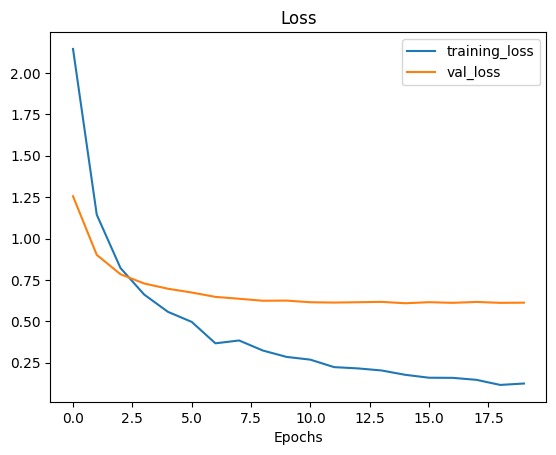

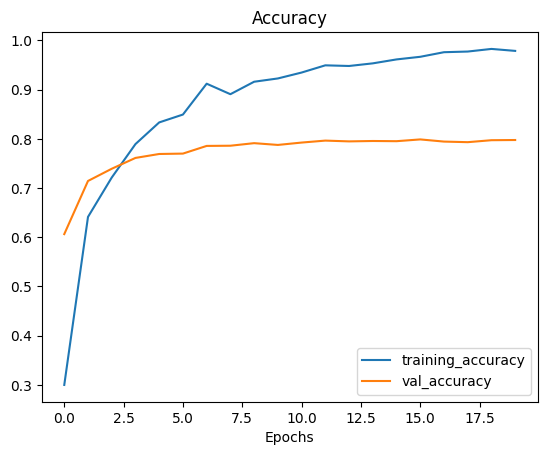

In [45]:
plot_loss_curves(resnet_history)


In [20]:
resnet_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [46]:

# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=50, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0"), early_stopping])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240227-105706
Epoch 1/50
24/24 [==============================] - 19s 465ms/step - loss: 1.9726 - accuracy: 0.3573 - val_loss: 1.3936 - val_accuracy: 0.6888
Epoch 2/50
24/24 [==============================] - 10s 426ms/step - loss: 1.1872 - accuracy: 0.7213 - val_loss: 0.9406 - val_accuracy: 0.8076
Epoch 3/50
24/24 [==============================] - 10s 410ms/step - loss: 0.8512 - accuracy: 0.8053 - val_loss: 0.7540 - val_accuracy: 0.8392
Epoch 4/50
24/24 [==============================] - 10s 423ms/step - loss: 0.7026 - accuracy: 0.8267 - val_loss: 0.6540 - val_accuracy: 0.8524
Epoch 5/50
24/24 [==============================] - 12s 532ms/step - loss: 0.5918 - accuracy: 0.8627 - val_loss: 0.5943 - val_accuracy: 0.8620
Epoch 6/50
24/24 [==============================] - 10s 426ms/step - loss: 0.5225 - accuracy: 0.8787 - val_loss: 0.5490 - val_accuracy: 0.8672
Epoch 7/50
24/24 [==============================] - 10s 418ms/s

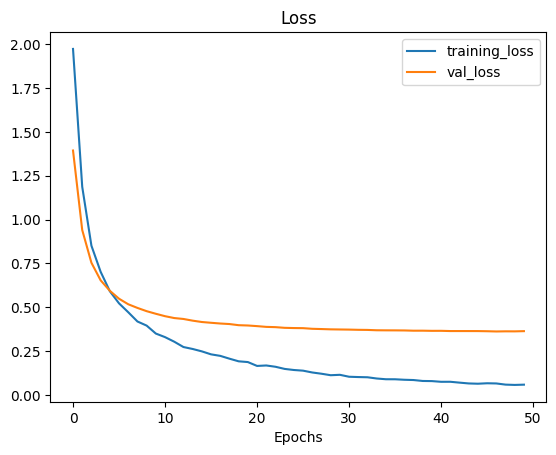

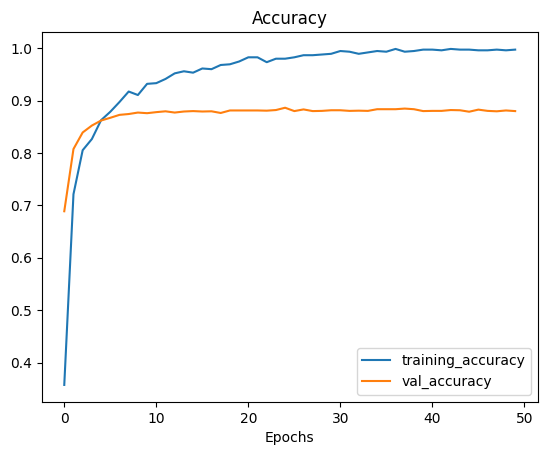

In [47]:
plot_loss_curves(efficientnet_history)


In [ ]:
pip install mlflow


In [28]:
mlflow ui


SyntaxError: invalid syntax (<ipython-input-28-9ad9f874b0b2>, line 1)

In [29]:
import mlflow

mlflow.set_experiment("EfficientNetB0 vs. ResNet50V2 Experiment")


2024/02/27 10:33:09 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB0 vs. ResNet50V2 Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/452215836485426690', creation_time=1709029989663, experiment_id='452215836485426690', last_update_time=1709029989663, lifecycle_stage='active', name='EfficientNetB0 vs. ResNet50V2 Experiment', tags={}>

In [30]:
mlflow.log_param("model", "EfficientNetB0 vs. ResNet50V2")
mlflow.log_param("description", "Comparing two different TF Hub feature extraction models architectures using 10% of training images")


'Comparing two different TF Hub feature extraction models architectures using 10% of training images'

In [31]:
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("loss", loss)


NameError: name 'accuracy' is not defined

In [33]:
mlflow.log_artifacts("/content/")


KeyboardInterrupt: 

In [48]:

# Create model
mobilenet_model = create_model(model_url=mobilenet_v2, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
mobilenet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
mobilenet_history = mobilenet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=10, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0"), early_stopping])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240227-110609
Epoch 1/10
24/24 [==============================] - 13s 414ms/step - loss: 2.6785 - accuracy: 0.2813 - val_loss: 1.2986 - val_accuracy: 0.5652
Epoch 2/10
24/24 [==============================] - 9s 389ms/step - loss: 1.2501 - accuracy: 0.5933 - val_loss: 0.8438 - val_accuracy: 0.7156
Epoch 3/10
24/24 [==============================] - 9s 407ms/step - loss: 0.8864 - accuracy: 0.6973 - val_loss: 0.7342 - val_accuracy: 0.7524
Epoch 4/10
24/24 [==============================] - 9s 376ms/step - loss: 0.7057 - accuracy: 0.7707 - val_loss: 0.6732 - val_accuracy: 0.7636
Epoch 5/10
24/24 [==============================] - 10s 420ms/step - loss: 0.5842 - accuracy: 0.8053 - val_loss: 0.6495 - val_accuracy: 0.7760
Epoch 6/10
24/24 [==============================] - 12s 538ms/step - loss: 0.4941 - accuracy: 0.8320 - val_loss: 0.6503 - val_accuracy: 0.7740
Epoch 7/10
24/24 [==============================] - 9s 406ms/step 

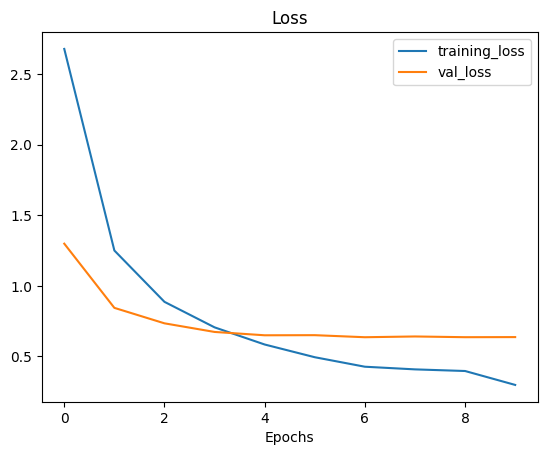

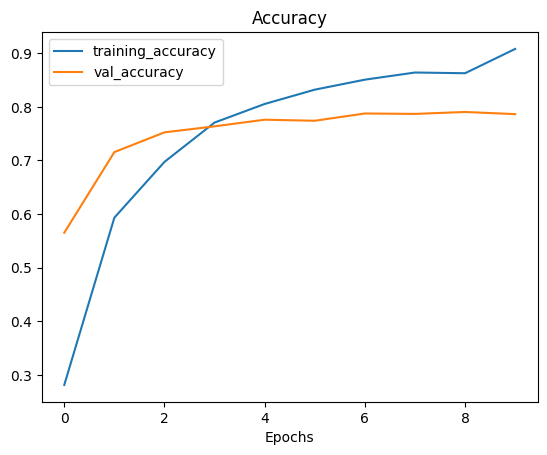

In [49]:
plot_loss_curves(mobilenet_history)


In [50]:

# Create model
inception_model = create_model(model_url=inception_v3, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
inception_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
inception_history = inception_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=50, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="inception"), early_stopping])

Saving TensorBoard log files to: tensorflow_hub/inception/20240227-110809
Epoch 1/50
24/24 [==============================] - 16s 466ms/step - loss: 3.6301 - accuracy: 0.2533 - val_loss: 1.5532 - val_accuracy: 0.5440
Epoch 2/50
24/24 [==============================] - 10s 437ms/step - loss: 1.7054 - accuracy: 0.5440 - val_loss: 1.0304 - val_accuracy: 0.6692
Epoch 3/50
24/24 [==============================] - 10s 424ms/step - loss: 1.2601 - accuracy: 0.6453 - val_loss: 0.9256 - val_accuracy: 0.7112
Epoch 4/50
24/24 [==============================] - 11s 454ms/step - loss: 1.0359 - accuracy: 0.6973 - val_loss: 0.8807 - val_accuracy: 0.7232
Epoch 5/50
24/24 [==============================] - 13s 538ms/step - loss: 0.8761 - accuracy: 0.7400 - val_loss: 0.8574 - val_accuracy: 0.7288
Epoch 6/50
24/24 [==============================] - 10s 439ms/step - loss: 0.8596 - accuracy: 0.7560 - val_loss: 0.8545 - val_accuracy: 0.7380
Epoch 7/50
24/24 [==============================] - 10s 438ms/step -

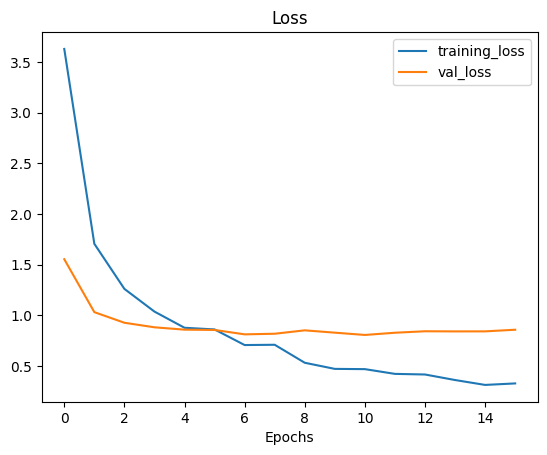

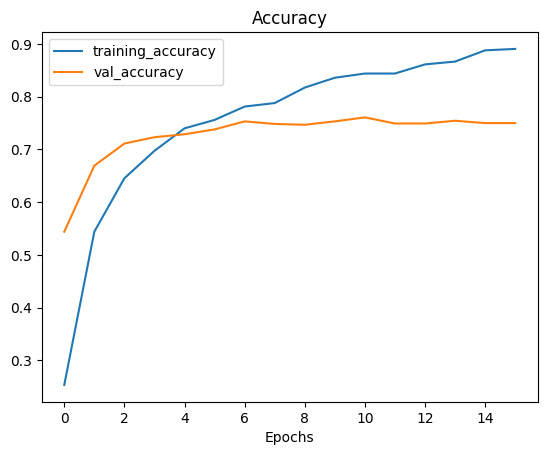

In [51]:
plot_loss_curves(inception_history)
